## Summary of changes

- use a dict to concat metadata
- show samplesets where > 1 country
- tidy up `offset_df` object
- use `dict.get()` to tidy up logic around label positions
- as above to tidy long names
- use of `pd.crosstab` instead of looping through and counting
- make logic of label positioning better- perhaps a misunderstanding of va param

## To do

- prefer to find better term than "intermediate", as clearly gamb_colu rather than arab. 
- better colour than grey
- tidy up offsets based on new text_va logic

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import seaborn as sns
import gcsfs
from pathlib import Path
import yaml
#cartopy text scale issues
sns.set_context('paper', font_scale=.9)

cartopy 0.17.0


### setup data access

In [2]:
gcsfs.core.client_config['installed']['client_id'] = '160816776314-7h1p2h6bqhe77vs1su4rr22fblso9dre.apps.googleusercontent.com'
gcsfs.core.client_config['installed']['client_secret'] = 'SrJUwD58yKgViyJtw-NP2sz8'

In [3]:
# create a GCSFileSystem just for the purpose of authentication
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

# create another one with those credentials
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials, cache_timeout=0)

### setup data

In [4]:
staging_dir = Path("vo_agam_release")
species_analysis = "species_calls_20200422"

In [5]:
#get pops
with open("../data/config.yml", "r") as yy:
    config = yaml.load(yy, Loader=yaml.Loader)

samplesets = sorted(config["sample_sets"])

#GA-B is empty, crosses we don't want
samplesets.remove('AG1000G-GA-B')
samplesets.remove('AG1000G-X')

In [6]:
#need to get mean lon/lat across countries so we might as well concat all metadata including species into a big PD
set_len = 0
all_meta = {}

for sset in samplesets:
        
        metadata_path = staging_dir / "v3" / "metadata" / "general" / sset / "samples.meta.csv"
        species_path = staging_dir / "v3" / "metadata" / species_analysis / sset / "samples.species_aim.csv"

        with gcs.open(metadata_path) as gcs_fh:
            df = pd.read_csv(gcs_fh, index_col=0)
        with gcs.open(species_path) as gcs_fh:
            df_aim = pd.read_csv(gcs_fh, index_col=0)

        # join on sample id
        result = pd.concat([df, df_aim], axis=1, sort=False)
        
        set_len += len(result)

        all_meta[sset] = result

all_meta = pd.concat(all_meta, names=["sample_set", "sample_id"]).reset_index(level=0)

assert len(all_meta) == set_len

In [7]:
all_meta.country = all_meta.country.str.replace("Gambia, The", "The Gambia").str.replace("Equatorial Guinea", "Bioko")

In [8]:
result.shape

(290, 13)

In [9]:
all_meta.shape

(2784, 14)

In [10]:
all_meta.head()

,sample_set,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii
sample_id,,,,,,,,,,,,,,
AR0047-C,AG1000G-AO,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.945,0.001,gamb_colu,coluzzii
AR0049-C,AG1000G-AO,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.933,0.001,gamb_colu,coluzzii
AR0051-C,AG1000G-AO,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.937,0.002,gamb_colu,coluzzii
AR0061-C,AG1000G-AO,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.938,0.002,gamb_colu,coluzzii
AR0078-C,AG1000G-AO,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.926,0.001,gamb_colu,coluzzii


In [11]:
df_centroids = pd.read_csv("../data/Africa_centroids.csv", index_col=0).rename(str.lower, axis=1)

In [12]:
# df_centroids = all_meta.groupby("country").agg({"latitude": np.mean, "longitude": np.mean})
df_centroids.head()

,pop_est,gdp_md_est,lastcensus,longitude,latitude
name_long,,,,,
Angola,12799293,110300.0,1970,17.537368,-12.293361
Burundi,8988091,3102.0,2008,29.875122,-3.359397
Benin,8791832,12830.0,2002,2.327853,9.641760
Burkina Faso,15746232,17820.0,2006,-1.754566,12.269538
Botswana,1990876,27060.0,2011,23.798534,-22.184032


In [13]:
all_meta.shape

(2784, 14)

In [14]:
sampleset_by_country = pd.crosstab(all_meta.sample_set, all_meta.country)

# any samplesets that have multiple countries? 
sampleset_by_country.loc[(sampleset_by_country > 0).sum(axis=1) > 1]

country,Angola,Bioko,Burkina Faso,Cameroon,Central African Republic,Cote d'Ivoire,Democratic Republic of Congo,Gabon,Ghana,Guinea,Guinea-Bissau,Kenya,Malawi,Mali,Mayotte,Mozambique,Tanzania,The Gambia,Uganda
sample_set,,,,,,,,,,,,,,,,,,,
AG1000G-GN-B,0,0,0,0,0,0,0,0,0,91,0,0,0,94,0,0,0,0,0


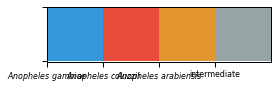

In [15]:
#countries
countries = list(all_meta.country.unique())
#long species labels
sp_nm = ['$Anopheles$ $gambiae$', '$Anopheles$ $coluzzii$', '$Anopheles$ $arabiensis$', 'intermediate']
#palette
flat = ["#3498db", "#e74c3c", "#e2962d", "#95a5a6"]
palette = sns.color_palette(flat, n_colors=len(sp_nm))
# add a colour for other_resistant
sns.palplot(palette)
plt.gca().set_xticklabels(sp_nm);

In [16]:
#build df with lat lon offsets and country labels - two letter codes?
offset_df = pd.DataFrame(index=countries, columns=["offset_lon", "offset_lat"], data=0.0)

In [17]:
offset_df.loc['Angola'] = 0, 2
offset_df.loc['Burkina Faso'] = 2, 0
offset_df.loc['Cameroon'] = -0.3, 1
offset_df.loc['Central African Republic'] = 0.3, 1
offset_df.loc["Cote d'Ivoire"] = -0.5, 0
offset_df.loc['Democratic Republic of Congo'] = 0, 3
offset_df.loc['Bioko'] = -3, -1.5
offset_df.loc['The Gambia'] = -4, 1
offset_df.loc['Ghana'] = 0.4, -1.5
offset_df.loc['Guinea-Bissau'] = -2.5, -3
offset_df.loc['Kenya'] = 0, 1
offset_df.loc['Malawi'] = -1, 0
offset_df.loc['Mali'] = 0, -1
offset_df.loc['Mayotte'] = -1, 3
offset_df.loc['Mozambique'] = 1, -2
offset_df.loc['Tanzania'] = 0, 1
offset_df.loc['Uganda'] = 0, 1

In [18]:
alternate_names = {
#     "Equatorial Guinea": "Bioko",
#     "Gambia, The": "The Gambia",
    "Central African Republic": "Central African Republic".replace(" ", "\n"),
    "Democratic Republic of Congo": "Democratic\nRepublic\nof Congo"
}

In [19]:
label_locations = {
    c: "bottom" for c in ['Central African Republic', 'Guinea', 'Burkina Faso', 'Mayotte', 'Democratic Republic of Congo', "Cote d'Ivoire"]}
label_locations

{'Central African Republic': 'bottom',
 'Guinea': 'bottom',
 'Burkina Faso': 'bottom',
 'Mayotte': 'bottom',
 'Democratic Republic of Congo': 'bottom',
 "Cote d'Ivoire": 'bottom'}

In [20]:
arab_call = pd.crosstab(all_meta.country, all_meta.species_gambcolu_arabiensis)
colu_call = pd.crosstab(all_meta.country, all_meta.species_gambiae_coluzzii)
colu_call.rename({"intermediate": "gambaie/coluzzii"}, axis=1, inplace=True)

In [21]:
summary_counts = pd.concat([arab_call, colu_call], axis=1, sort=False).fillna(0).astype(int)
summary_counts.drop("gamb_colu", axis=1, inplace=True)

In [22]:
summary_counts.head()

,arabiensis,intermediate,coluzzii,gambiae,gambaie/coluzzii
Angola,0,0,81,0,0
Bioko,0,0,0,10,0
Burkina Faso,3,0,135,157,1
Cameroon,2,0,26,416,0
Central African Republic,0,0,18,55,0


In [23]:
ar, _, cl, ga, it = summary_counts.loc["Mali"]

In [24]:
#code to get a single averaged lat/lon and species composition for each country
def plot_pyr_map(dpi=150, extent=[-23, 48, -20, 17.5], figsize=(10, 4), label_fontsize=7):
    
    subplot_kw = dict(projection=ccrs.PlateCarree())
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw, dpi=120)
    ax.add_feature(cfeature.LAND, linewidth=1, zorder=1)
    ax.coastlines(resolution='50m', linewidth=0.7, zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=5)
    
    for c in countries:
        
        ar, _, cl, gm, it = summary_counts.loc[c]
        
        #use centroids for countries +- offsets
        offset_lon = offset_df.loc[c].offset_lon
        offset_lat = offset_df.loc[c].offset_lat
        
        lon = df_centroids.loc[c].longitude
        lat = df_centroids.loc[c].latitude

        centre = (lon + offset_lon, lat + offset_lat)
        radius = np.sqrt(summary_counts.loc[c].sum() * .02)
        text_offset = (radius + (0.1 * radius))
        
        ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='k', zorder=8, lw=1))
        ax.pie([gm, cl, ar, it], wedgeprops=dict(zorder=7), colors=palette, center=centre, radius=radius, shadow=True)
        
        # assume we want label above the pie unless otherwise specified
        # if we want the text to appear _below_ the pie- we need to:
        # substract radius etc (text_offset)
        # set the text vertical alignment to "top"
        
        # otherwise... 
        # the vertical offset should be positive
        # the va should be "bottom"
        
        text_pos = label_locations.get(c, "top")
        text_va = "bottom"
        
        # text_va is therefore bottom if top, and top if bottom.
        if text_pos == "bottom":
            text_va = "top"
            text_offset = -text_offset
        
        long_label = alternate_names.get(c, c)
        
        ax.text(
            centre[0], 
            centre[1] + text_offset, 
            long_label, 
            ha='center', 
            va=text_va,
            fontsize=6, 
            fontweight='bold', 
            bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8, ), 
            zorder=6)
        
        # plot a line if there is an offset
        if offset_lat != 0 or offset_lon != 0:
            ax.plot([lon, lon + offset_lon],[lat, lat + offset_lat], 'k-', lw=1, zorder=5)
            
        
    #manual colour legend
    plt.text(-12.0, -1.3, 'Species', fontsize=8,fontweight='bold')
    
    plt.plot([-14.5, -17.6],[-4, -4], color=flat[0], lw=8, zorder=20, solid_capstyle='round')
    plt.text(-13,-4.7,  sp_nm[0], fontsize=8 )
    
    plt.plot([-14.5, -17.6],[-7, -7], color=flat[1], lw=8, zorder=20, solid_capstyle='round')
    plt.text(-13,-7.7, sp_nm[1], fontsize=8 )
    
    plt.plot([-14.5, -17.6],[-10, -10], color=flat[2], lw=8, zorder=20, solid_capstyle='round')
    plt.text(-13,-10.7, sp_nm[2], fontsize=8 )
    
    plt.plot([-14.5, -17.6],[-13, -13], color=flat[3], lw=8, zorder=20, solid_capstyle='round')
    plt.text(-13,-13.7, sp_nm[3], fontsize=8 )
    
    
    #cover tiny islands
    plt.plot([-17, -15],[-6.5, -6.5], 'w', lw=20, zorder=10)
    plt.plot([-6.5, -6],[-15, -15], 'w', lw=20, zorder=3)      

    #X0,X1,Y0,Y1  extent format  
    ax.set_extent(extent)         
    fig.savefig('../artwork/collection_map.pdf', dpi=dpi, bbox_inches='tight');
    return ax

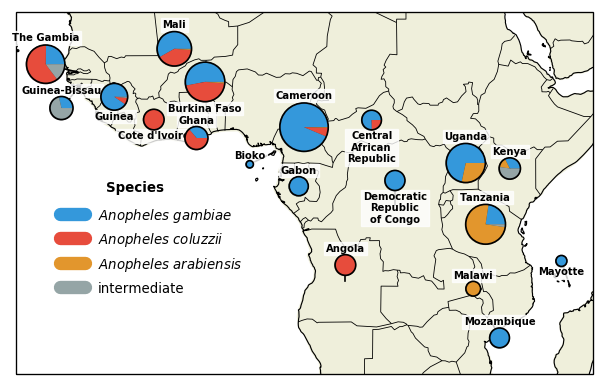

In [25]:
a = plot_pyr_map()